In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

### Monte Carlo simulation of Stock Price Paths

In [2]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1, M))
    return S

### Compute the Payoff

In [3]:
def payoff_fun(S, K):
    return np.maximum(K - S, 0)

### Create Shallow Neural Network

In [4]:
def create_shallow_NN(input_dim, hidden_units):
    
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    return model

In [25]:
S0 = 1
K = 1.2
mu = 0.1
sigma = 0.2
T = 1
N = 252
M = 5000

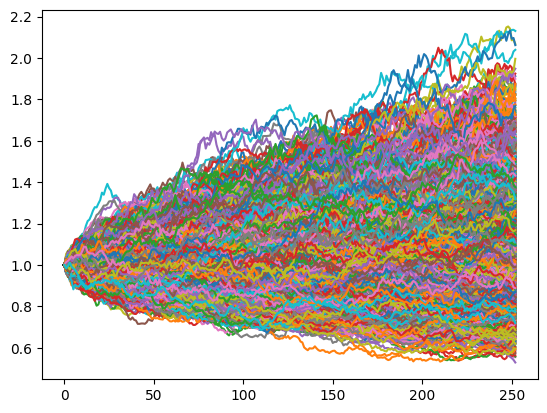

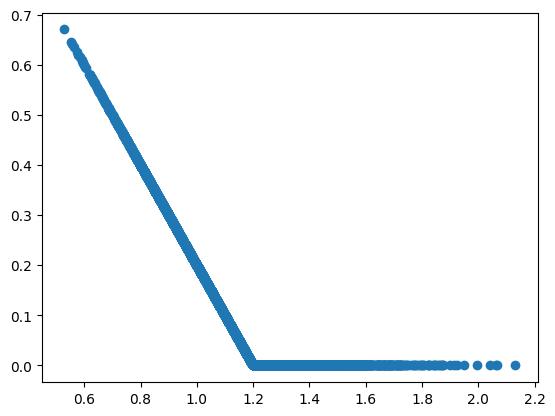

In [26]:
stock_paths = stock_price_simulator(S0, mu, sigma, T, N, M)
plt.plot(stock_paths.T)
plt.show()
payoffs_at_maturity = payoff_fun(stock_paths[:, -1], K)
plt.scatter(stock_paths[:,-1], payoffs_at_maturity)
plt.show()

In [27]:
X = stock_paths[:, -1].reshape(-1, 1)
y = payoffs_at_maturity.reshape(-1, 1)
X.shape, y.shape

((5000, 1), (5000, 1))

In [28]:
X = StandardScaler().fit_transform(X)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
model = create_shallow_NN(1, 8)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mean_squared_error')

In [31]:
# Set up early stopping based on validation loss with a patience of 6 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


In [32]:
# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Provide validation data for monitoring
    epochs=100,                       # Set a high max epoch count; early stopping will limit training
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.0932 - val_loss: 0.0075
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - loss: 0.0064 - val_loss: 0.0036
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 0.0031 - val_loss: 0.0015
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.0013 - val_loss: 5.5939e-04
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 4.9204e-04 - val_loss: 2.5111e-04
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 2.3522e-04 - val_loss: 1.6338e-04
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 1.6135e-04 - val_loss: 1.3646e-04
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 1.4012e-04 - val_loss: 1.1908e-04
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 1.2211e-04 - val_loss: 1.0282e-04
Epoch 10/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 9.8498e-05 - val_loss: 8.4564e-05
Epoch 11/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step -

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


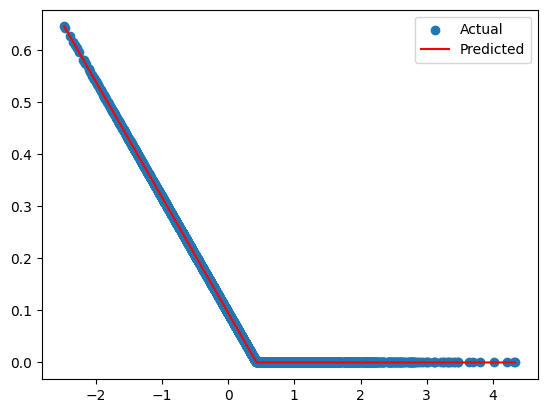

In [33]:
# Test the model
y_hat = model.predict(X_train)
plt.scatter(X_train, y_train, label='Actual')
# Sort X_train and y_hat for a smoother line plot
sorted_indices = np.argsort(X_train[:, 0])  # Sort based on the first (and only) feature
X_train_sorted = X_train[sorted_indices]
y_hat_sorted = y_hat[sorted_indices]
plt.plot(X_train_sorted, y_hat_sorted, label='Predicted', color='r')
plt.legend()

### Continuation Value

In [34]:
def expected_value(wi, bi, Stm):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi > 0 and bi > 0:
        # Case 1: Price of a forward contract
        return wi * Stm + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        return wi * max(Stm - strike, 0)

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        # Using max(0, strike - Stm) to approximate the expectation
        return -wi * max(strike - Stm, 0)

    elif wi < 0 and bi < 0:
        # Case 4: Expected value is 0
        return 0.0


In [35]:
model.layers[0].get_weights()[1]

array([ 0.15706825,  0.00041325, -0.00168632,  0.01761843, -0.00024193,
       -0.00941313, -0.01022201,  0.01327494], dtype=float32)

### 0 bias and weightr was problem

In [36]:
from scipy.stats import norm

In [37]:
def analytical_expected_value(stm_1 , r, sigma, wi , bi, dt= 0.5):
    mu_y = wi * (stm_1 + (r - 0.5 * sigma**2)) * dt + bi
    sigma_y = sigma * np.sqrt(dt)
    
    first_term = sigma_y / np.sqrt(2 * np.pi) * np.exp(-mu_y**2 / (2 * sigma_y**2)) 
    second_term =  mu_y * (1 - norm.cdf(-mu_y))
    return first_term + second_term

In [38]:
no_hidden_units = 8
b2 = model.layers[1].get_weights()[1][0]

r = 0.1
sigma = 0.2

continuation_value = np.zeros(M)
for j in range(M):
    for i in range(no_hidden_units):
        wi = model.layers[0].get_weights()[0][0][i]
        bi = model.layers[0].get_weights()[1][i]
        w2 = model.layers[1].get_weights()[0][i][0]
        continuation_value[j] += analytical_expected_value(stock_paths[j][-125], r, sigma, wi, bi) * w2
    continuation_value[j] += b2
print(continuation_value)

[0.04511997 0.01010687 0.00940296 ... 0.01330253 0.02238714 0.03744946]


In [39]:
payoff_at2 = payoff_fun(np.exp(stock_paths[:, -125]), K)

In [40]:
Vt_m_1 = np.maximum(payoff_at2, continuation_value)

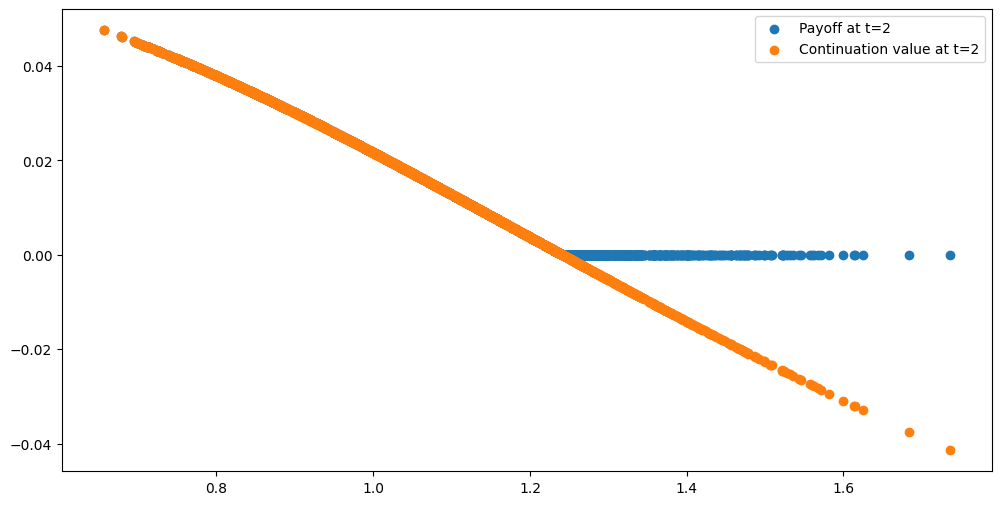

In [42]:
plt.figure(figsize=(12, 6))
plt.scatter(stock_paths[:, -125], Vt_m_1, label='Payoff at t=2')
plt.scatter(stock_paths[:, -125], continuation_value, label='Continuation value at t=2')
plt.legend()

In [44]:
weights_tm = model.get_weights()  # Save the weights after training on t_m

# Step 2: Initialize a new model for date t_{m-1} and load weights from t_m
model_tm1 = create_shallow_NN(input_dim=1, hidden_units=8)
model_tm1.set_weights(weights_tm) 

In [45]:
X_tm1 = stock_paths[:, -125].reshape(-1, 1)
y_tm1 = Vt_m_1.reshape(-1, 1)

In [46]:
X_tm1_train, X_tm1_val, y_tm1_train, y_tm1_val = train_test_split(X_tm1, y_tm1, test_size=0.3, random_state=42)

In [47]:
# Step 3: Compile and train model for date t_{m-1} starting from transferred weights
model_tm1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # Compile the model
model_tm1.fit(X_tm1_train, y_tm1_train, validation_data= (X_tm1_val, y_tm1_val), 
              epochs=100, 
              batch_size=16,
              callbacks=[early_stopping],
              verbose=1)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 1.2615e-04 - val_loss: 1.1373e-05
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - loss: 9.4082e-06 - val_loss: 7.8608e-06
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 7.8833e-06 - val_loss: 7.2071e-06
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 9.2730e-06 - val_loss: 6.4406e-06
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 9.1565e-06 - val_loss: 5.9199e-06
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 8.7985e-06 - val_loss: 6.4281e-06


In [48]:
y_tm1_hat = model_tm1.predict(X_tm1_train)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


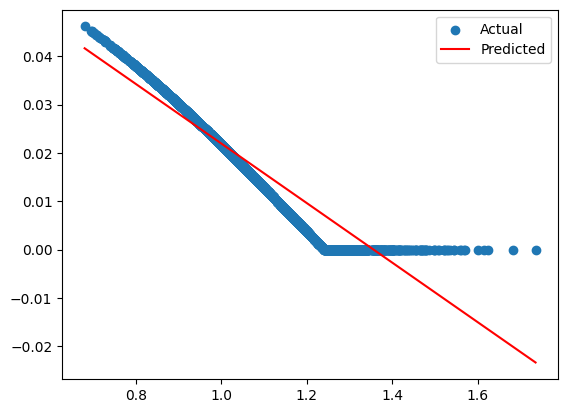

In [49]:
plt.scatter(X_tm1_train, y_tm1_train, label='Actual')
# Sort X_train and y_hat for a smoother line plot
sorted_indices = np.argsort(X_tm1_train[:, 0])  # Sort based on the first (and only) feature
X_tm1_train_sorted = X_tm1_train[sorted_indices]
y_tm1_hat_sorted = y_tm1_hat[sorted_indices]
plt.plot(X_tm1_train_sorted, y_tm1_hat_sorted, label='Predicted', color='r')
plt.legend()
